https://openpiv.readthedocs.io/en/latest/src/tutorial1.html

# Imports 

In [12]:
from openpiv import tools, pyprocess, validation, filters, scaling

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import importlib_resources
import pathlib

# Initial Set Up

In [13]:
path = importlib_resources.files('openpiv')
output_path = "C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/code/src/data/processed"

Text(0.5, 1.0, 'Frame 2')

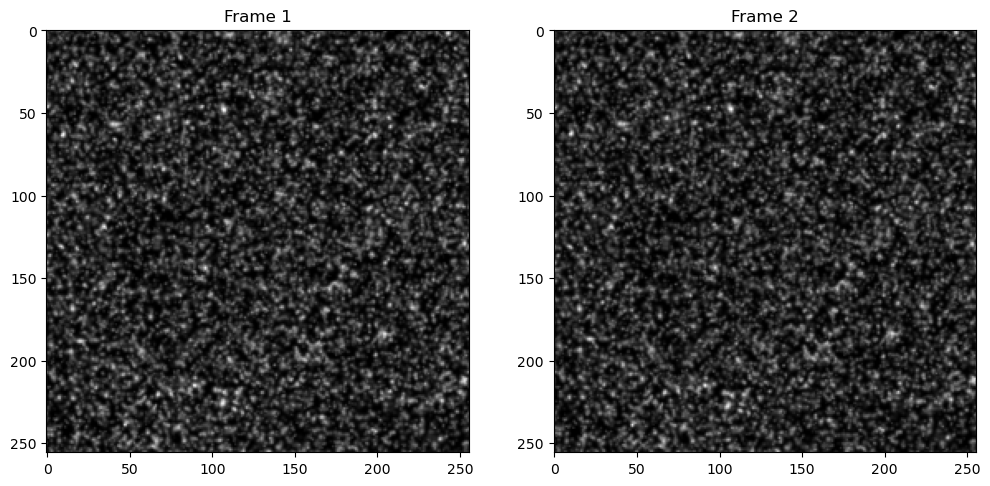

In [14]:
frame_a  = tools.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/DNS_test/DNS_turbulence_00001_img1.tif')
frame_b  = tools.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/DNS_test/DNS_turbulence_00001_img2.tif')

fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray);
ax[0].set_title("Frame 1")
ax[1].imshow(frame_b,cmap=plt.cm.gray);
ax[1].set_title("Frame 2")

# Processing

## Standard PIV cross-correlation algorithm.

**Inputs**

Allows the search area (search_area_size) in the second frame to be larger than the interrogation window in the first frame (window_size). Also, the search areas can overlap (overlap).

**Outputs**

1. The u component of the velocity vectors 
2. The v component of the velocity vectors 
3. The signal-to-noise ratio (S2N) of the cross-correlation map of each vector. The higher it is, the more confidence on having the correct velocity.

In [15]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search area size in frame B
overlap = 17 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

## Get Maximum correlation coordinates

Finds the center of each interrogation window with higher correlation coefficient

In [16]:
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)

## Post-Processing

sig2noise_val

In [17]:
invalid_mask = validation.sig2noise_val(
    sig2noise,
    threshold = 1.05,
)

In [18]:
u2, v2 = filters.replace_outliers(
    u0, v0,
    invalid_mask,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

Flip the coordinate system and convert pixel to mm

In [19]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(
    x, y, u2, v2,
    scaling_factor = 96.52,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [20]:
tools.save('exp1_001.txt' , x, y, u3, v3, invalid_mask)

# Viusalization

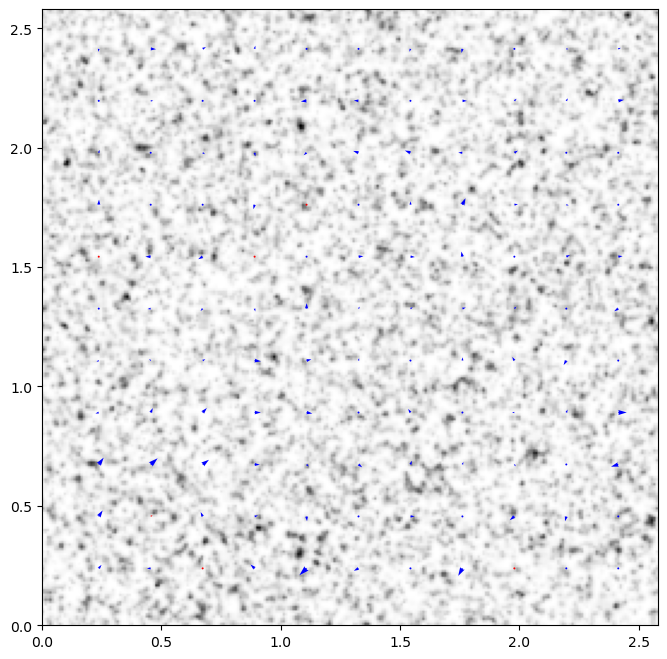

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    pathlib.Path('exp1_001.txt'),
    ax=ax, scaling_factor=96.52,
    scale=50, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= str('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/DNS_test/DNS_turbulence_00001_img1.tif'),
);